In [311]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC, DiagGGNExact
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
#from scipy.stats import pearsonr
#from mpl_toolkits.axes_grid1 import AxesGrid
#import mpl_toolkits as mpl
#from scipy.stats import chi2, norm
#import random
#import warnings
#warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, linregress
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import random

#plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#plt stuff
plt.rcParams["figure.figsize"] = (20,10)

In [312]:
#scatterlist = []

In [735]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

def flattenlist(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

## Create Dataset

In [829]:
class NumbersDataset(Dataset):
    
    def __init__(self):
        self.mean = 0
        self.std = 0.2 #0.6
        self.size = 5000
        self.mult = 2
        self.exp = 3
        self.noise = np.random.normal(loc=self.mean, scale=self.std, size=self.size)
        self.nums = np.linspace(-20, 30, self.size)
        #self.nums = self.nums + self.noise
        self.samples = []#torch.cat([self.nums + self.noise, 2*self.nums]).view(-1,2)
        for i, elem in enumerate(self.nums):
            self.samples.append((elem + self.noise[i] , elem **self.exp))
        #self.samples = torch.tensor(self.samples)
    def __noise__(self):
        return self.noise
    
    def __shape__(self):
        return self.samples.size()
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        num, label = self.samples[idx]
        return num, label
        #$return self.samples[idx]
    
    def __plot__(self):
        inpt = []
        targ = []
        for tuplee in self.samples:
            inpt.append(tuplee[0])
            targ.append(tuplee[1])
        plt.scatter(inpt, targ)
        #plt.show()

if __name__ == '__main__':
    dataset = NumbersDataset()
    trainset, testset = random_split(dataset, [4000, 1000])
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)#, num_workers=2)
    testloader = DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)
    #print(len(dataset
    #print(dataset[99])
    #print(dataset[0])
    for i, batch in enumerate(trainloader):
        if i > 0:
            break
        print(i, batch)
        

0 [tensor([ -3.8776, -11.5654,   5.0247,  -8.7869,   1.8340,  -4.9309,  -9.0544,
         -7.0813,  24.6350, -15.3589,  27.8071, -14.3739,  11.3703,   8.9725,
         -4.3147,  26.6047,   3.0430,  -8.6828, -14.3074,   6.1355,  -4.1333,
         19.8090,  -0.4967,  -3.8909,  25.1883,  -4.6508,  13.5911,  26.1578,
         28.4521,  27.5784, -18.8912,  15.3795,  17.3927,  18.3858,  -2.3337,
          3.9853, -16.4614,  21.7098,  -1.6670,  23.1194,  23.2894,  15.6573,
         -7.5370,  -3.5272, -10.5725,  16.4664,  -1.0320, -12.2837,  12.8296,
        -12.5824, -15.0428, -10.8249, -15.4755,   7.1715, -18.9307, -11.7738,
         26.0409,  -3.7041,  28.3915,  15.0804,  23.2672,  -0.3988,  26.6011,
         -6.3904], dtype=torch.float64), tensor([-6.4810e+01, -1.3855e+03,  1.2463e+02, -5.9433e+02,  5.2168e+00,
        -1.3320e+02, -7.2362e+02, -3.8384e+02,  1.5418e+04, -3.6587e+03,
         2.2045e+04, -2.9420e+03,  1.4415e+03,  7.3529e+02, -6.8258e+01,
         1.8566e+04,  2.3506e+01, -

## Define Perceptron

In [1]:
## Define Perceptron
def NN(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(1, sz), 
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz), #good
        torch.nn.ReLU(),
        #extension starts here
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),#good
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        torch.nn.Linear(sz, 1)
        #torch.nn.ReLU()
        
    )
    return(features)

def NN_deep(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(1, sz), 
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz), #good
        torch.nn.ReLU(),
        #extension starts here
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),#good
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        torch.nn.Linear(sz, 1)
        #torch.nn.ReLU()
        
    )
    return(features)

net = NN(sz= 4)

lossfunction = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(net.parameters() , lr = 0.01)#, momentum= 0.9)

NameError: name 'torch' is not defined

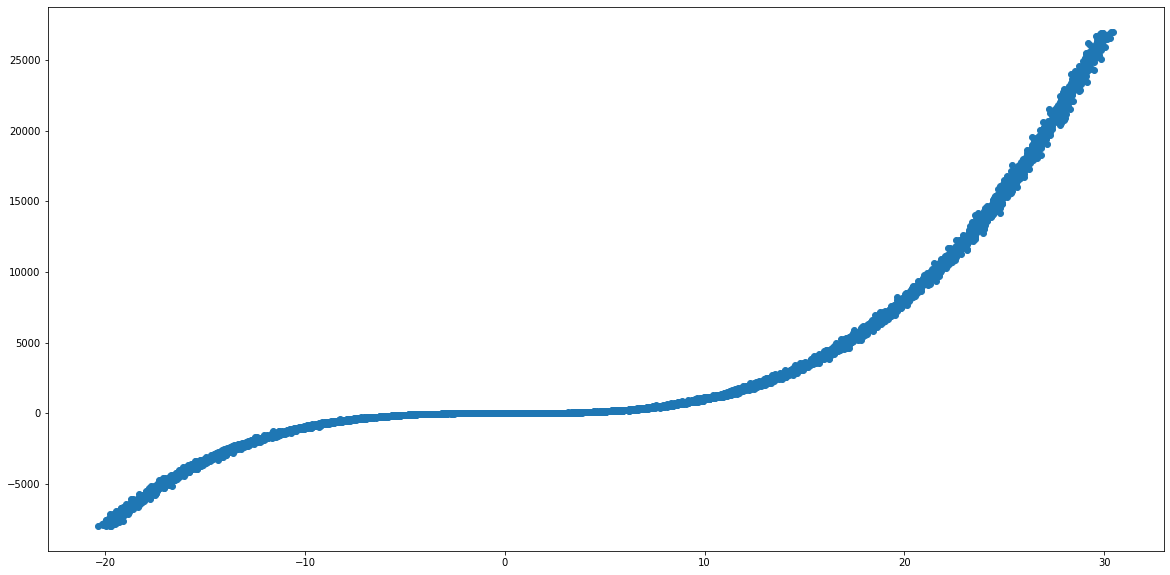

In [830]:
plt.rcParams["figure.figsize"] = (20,10)
dataset.__plot__()

## Define training procedure

In [918]:
def trainloop():
    
    for epoch in range(800):
        for i, (inputs, targets) in enumerate(trainloader):
            X, Y = inputs.float(), targets.float()
            X, Y =  X.view(X.size(0), -1), Y.view(Y.size(0), -1)
            #print(X, Y)
            #print(X, Y)
            #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)
            optimizer.zero_grad()
            outputs = net(X)
            loss = lossfunction(outputs, Y)
            loss.backward()
            optimizer.step()
            if (i % 1000 == 0):
                print("Epoch {} - loss: {}".format(epoch, loss.data.item()))
    

In [919]:
trainloop()

Epoch 0 - loss: 57934208.0
Epoch 1 - loss: 66533304.0
Epoch 2 - loss: 14665705.0
Epoch 3 - loss: 12980937.0
Epoch 4 - loss: 8067276.0
Epoch 5 - loss: 4227312.5
Epoch 6 - loss: 4891739.0
Epoch 7 - loss: 2866370.25
Epoch 8 - loss: 3693437.0
Epoch 9 - loss: 4134968.5
Epoch 10 - loss: 4185107.25
Epoch 11 - loss: 3043083.0
Epoch 12 - loss: 4330767.5
Epoch 13 - loss: 4136477.0
Epoch 14 - loss: 4980084.5
Epoch 15 - loss: 5446789.5
Epoch 16 - loss: 5759473.0
Epoch 17 - loss: 2982401.0
Epoch 18 - loss: 4718208.5
Epoch 19 - loss: 3339265.25
Epoch 20 - loss: 3860108.0
Epoch 21 - loss: 2586100.75
Epoch 22 - loss: 2243262.0
Epoch 23 - loss: 594659.625
Epoch 24 - loss: 122261.2890625
Epoch 25 - loss: 156720.5
Epoch 26 - loss: 111117.53125
Epoch 27 - loss: 129556.84375
Epoch 28 - loss: 196177.625
Epoch 29 - loss: 66113.4296875
Epoch 30 - loss: 381344.8125
Epoch 31 - loss: 55264.6953125
Epoch 32 - loss: 83758.203125
Epoch 33 - loss: 248890.5625
Epoch 34 - loss: 122920.3984375
Epoch 35 - loss: 50161.77

Epoch 268 - loss: 54428.609375
Epoch 269 - loss: 94167.8515625
Epoch 270 - loss: 200116.328125
Epoch 271 - loss: 50026.890625
Epoch 272 - loss: 54517.16015625
Epoch 273 - loss: 83737.078125
Epoch 274 - loss: 40610.1875
Epoch 275 - loss: 29947.09765625
Epoch 276 - loss: 40608.484375
Epoch 277 - loss: 207039.796875
Epoch 278 - loss: 98203.9609375
Epoch 279 - loss: 40084.8984375
Epoch 280 - loss: 34638.43359375
Epoch 281 - loss: 78062.765625
Epoch 282 - loss: 70460.8515625
Epoch 283 - loss: 86115.75
Epoch 284 - loss: 42254.328125
Epoch 285 - loss: 68260.5625
Epoch 286 - loss: 53757.05859375
Epoch 287 - loss: 83207.125
Epoch 288 - loss: 98423.921875
Epoch 289 - loss: 54127.90625
Epoch 290 - loss: 43353.31640625
Epoch 291 - loss: 118332.84375
Epoch 292 - loss: 87915.0703125
Epoch 293 - loss: 42385.83203125
Epoch 294 - loss: 48017.03515625
Epoch 295 - loss: 103155.8359375
Epoch 296 - loss: 66777.6484375
Epoch 297 - loss: 58676.72265625
Epoch 298 - loss: 61241.4453125
Epoch 299 - loss: 196986

Epoch 530 - loss: 215903.0
Epoch 531 - loss: 31638.83984375
Epoch 532 - loss: 36284.05859375
Epoch 533 - loss: 132651.859375
Epoch 534 - loss: 115011.15625
Epoch 535 - loss: 49342.0
Epoch 536 - loss: 127564.890625
Epoch 537 - loss: 120326.796875
Epoch 538 - loss: 158046.703125
Epoch 539 - loss: 56040.17578125
Epoch 540 - loss: 87044.2421875
Epoch 541 - loss: 71210.3984375
Epoch 542 - loss: 61017.69140625
Epoch 543 - loss: 89081.9609375
Epoch 544 - loss: 114402.953125
Epoch 545 - loss: 57248.203125
Epoch 546 - loss: 82314.7734375
Epoch 547 - loss: 55735.2265625
Epoch 548 - loss: 53610.1875
Epoch 549 - loss: 32471.49609375
Epoch 550 - loss: 62274.33203125
Epoch 551 - loss: 38954.19140625
Epoch 552 - loss: 56424.1953125
Epoch 553 - loss: 43907.3203125
Epoch 554 - loss: 179970.53125
Epoch 555 - loss: 105725.28125
Epoch 556 - loss: 127967.8828125
Epoch 557 - loss: 73925.7265625
Epoch 558 - loss: 79067.2890625
Epoch 559 - loss: 106050.0625
Epoch 560 - loss: 85683.84375
Epoch 561 - loss: 5215

Epoch 792 - loss: 19929.998046875
Epoch 793 - loss: 50815.16796875
Epoch 794 - loss: 61971.61328125
Epoch 795 - loss: 74959.5546875
Epoch 796 - loss: 54236.46484375
Epoch 797 - loss: 165974.21875
Epoch 798 - loss: 165680.84375
Epoch 799 - loss: 50407.1015625


In [841]:
def fitting(state, size):    
    mpl.rcParams['agg.path.chunksize'] = 10000
    model = NN(size)
    model.load_state_dict(state)
    
    inp = []
    outp = []
    targs = []
    max_len = len(testloader)
    for batch_idx, (inputs, targets) in enumerate(testloader):
            X, Y = inputs.float(), targets.float() #iter(data2)
            X, Y =  X.view(X.size(0), -1), Y.view(Y.size(0), -1)
            inp.append(X)
            targs.append(Y)
            output = model(X)
            outp.append(output)
    inp, outp, targs = torch.tensor(flattenlist(inp)), torch.tensor(flattenlist(outp)), torch.tensor(flattenlist(targs))    


    plt.plot(list(inp),list(outp), 'yo')#, inp, targs, '--k')
    #plt.plot(inp,targs, 'yo')
    dataset.__plot__()
    #plt.xlim(-20, 30)
    #plt.ylim(-40, 60)
    plt.show()

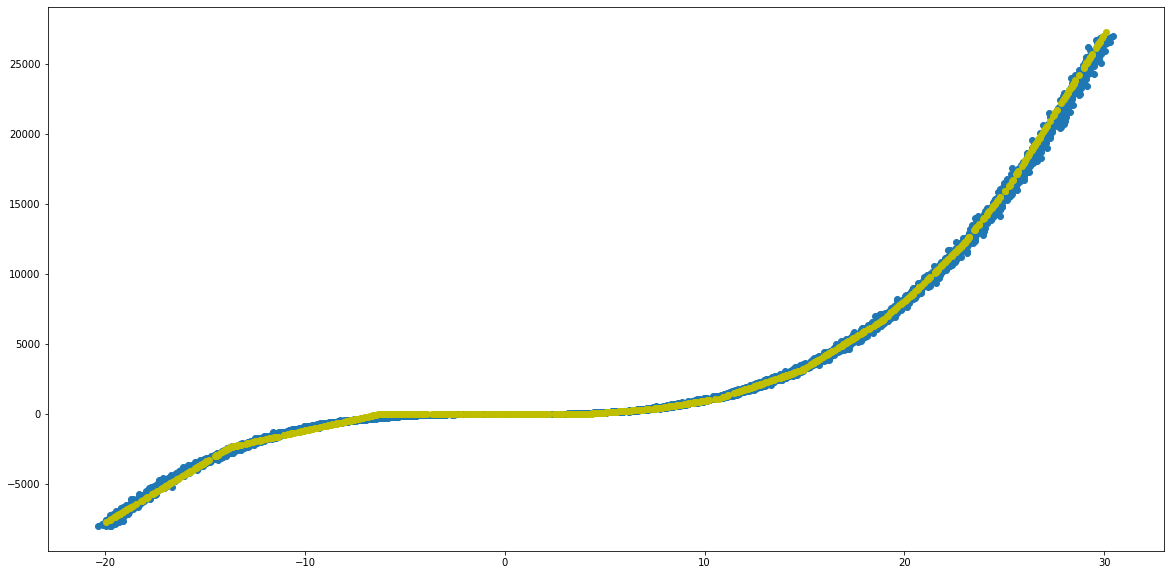

In [920]:
#plt.plot(inp, outp)
#plt.plot(inp.tolist(), outp.tolist())
fitting(net.state_dict(), 4)

In [597]:
#slope : slope of the regression line
#intercept : intercept of the regression line
#r-value : correlation coefficient
#p-value : two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero
#stderr : Standard error of the estimate

print('trained:')
print(linregress(inp,outp))
print()
print('dataset:')
print(linregress(inp,targs))

trained:
LinregressResult(slope=11.638749849072617, intercept=168.9502892658287, rvalue=0.6411609206674822, pvalue=6.679266569700177e-13, stderr=1.4071866382886555)

dataset:
LinregressResult(slope=11.572192815241694, intercept=170.19157866197065, rvalue=0.6368511684542557, pvalue=1.060786148564057e-12, stderr=1.4151797167399967)


### see if network trained correct weight

In [752]:
#print(list(net.named_parameters()))
#print()
print(net(Variable(torch.Tensor([[[3]]]))))

tensor([[[29.8981]]], grad_fn=<AddBackward0>)


## calculate Hessians: DiagHessian

In [835]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = lossfunction

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):
            
            
            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()
            else:
                x, y = torch.tensor(x).float(), torch.tensor(y).float()
            #print(x, y)

            model.zero_grad()
            x, y = x.view(-1, 1), y.view(-1, 1) 
                        
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #print(H_)
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [836]:
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)

parameter size:  torch.Size([5, 1])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([1, 5])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [869]:
#print(perceptronDiagH)#[0].item())
#print(perceptronDiagGGN)

## Analyze x**3 (depth: 6 hl)

### size 5

In [838]:
#x3state_5 = net.state_dict()

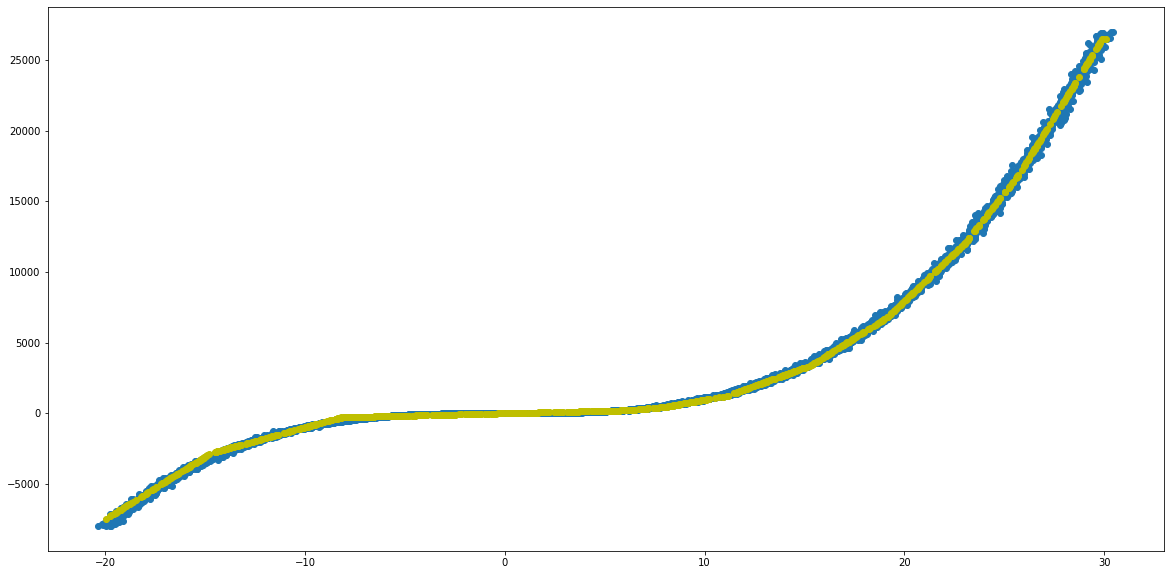

In [842]:
fitting(x3state_5, 5)

In [847]:
net = NN(sz=5)
net.load_state_dict(x3state_5)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([5, 1])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([1, 5])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.0001)
tensor(2.5301)
tensor(2.9093)
tensor(1.9009)
tensor(0.8944)
tensor(0.6381)


### size 10 

In [851]:
#x3state_10 = net.state_dict()

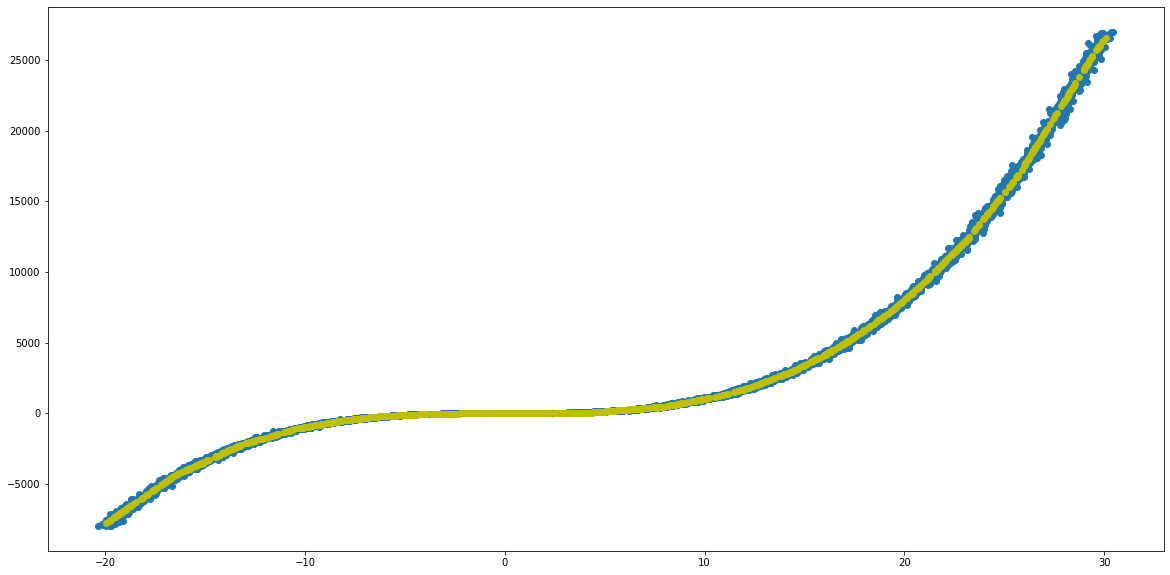

In [852]:
fitting(x3state_10, 10)

In [853]:
net = NN(sz=10)
net.load_state_dict(x3state_10)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([10, 1])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([1, 10])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1.2652)
tensor(2.4473)
tensor(2.1847)
tensor(2.2332)
tensor(1.9106)
tensor(1.5994)


### size 20

In [857]:
#x3state_20 = net.state_dict()

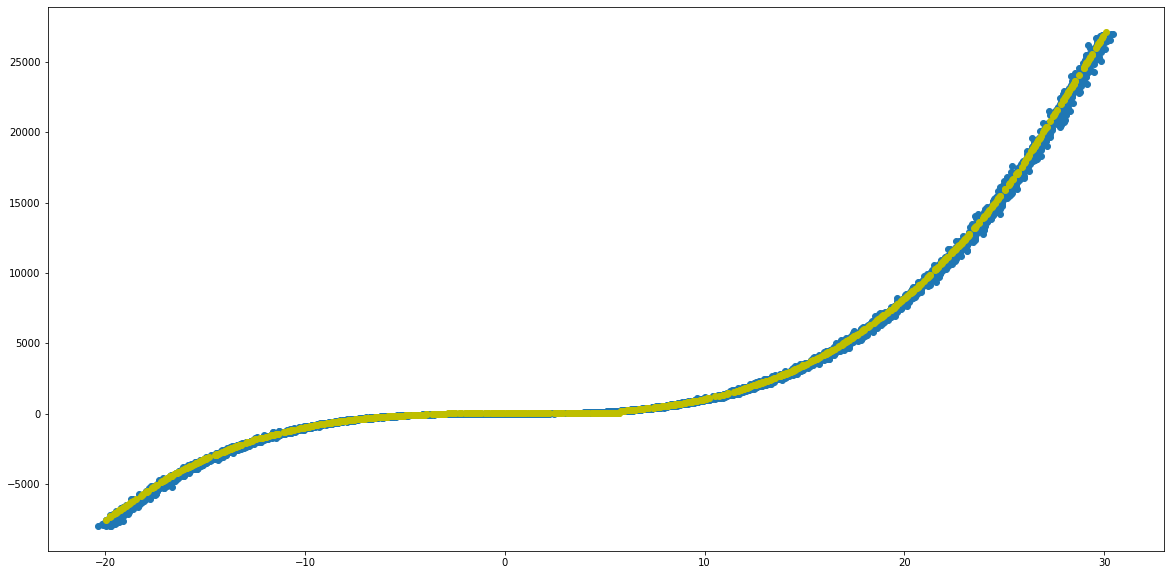

In [858]:
fitting(x3state_20, 20)

In [859]:
net = NN(sz=20)
net.load_state_dict(x3state_20)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([20, 1])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([1, 20])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1.9050)
tensor(2.8421)
tensor(2.6168)
tensor(2.4442)
tensor(2.5393)
tensor(1.4245)


In [866]:
#x3state_160 = net.state_dict()

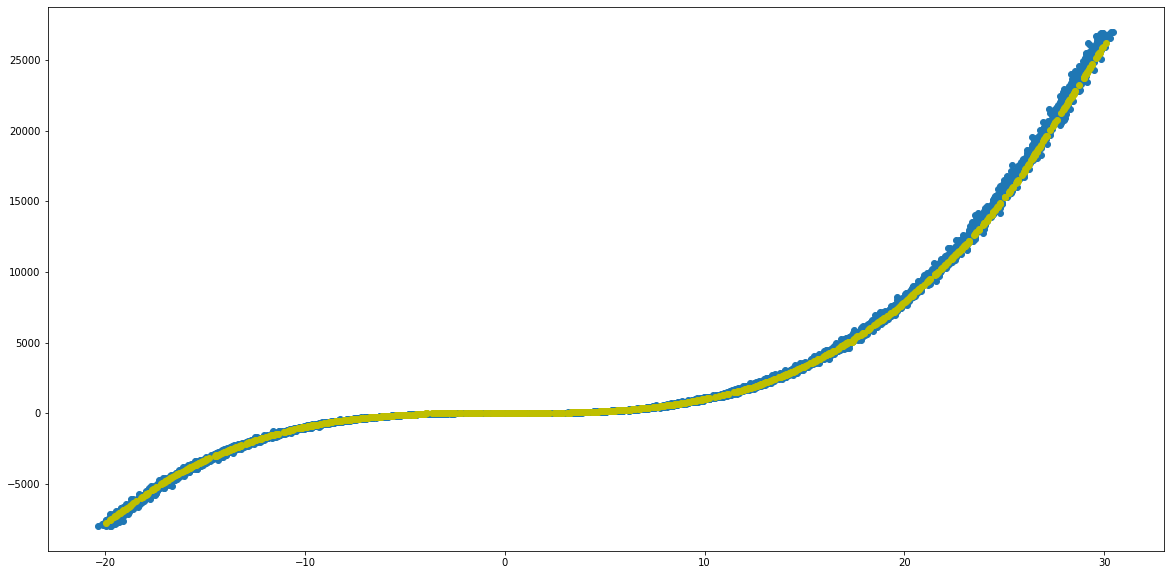

In [867]:
fitting(x3state_160, 160)

In [868]:
net = NN(sz=160)
net.load_state_dict(x3state_160)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([160, 1])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([1, 160])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(2.8280)
tensor(3.1590)
tensor(3.1597)
tensor(3.1438)
tensor(3.0983)
tensor(2.6205)


## x**3 (depth: 10)

### size 5

In [880]:
#x3state_5_deep = net.state_dict()

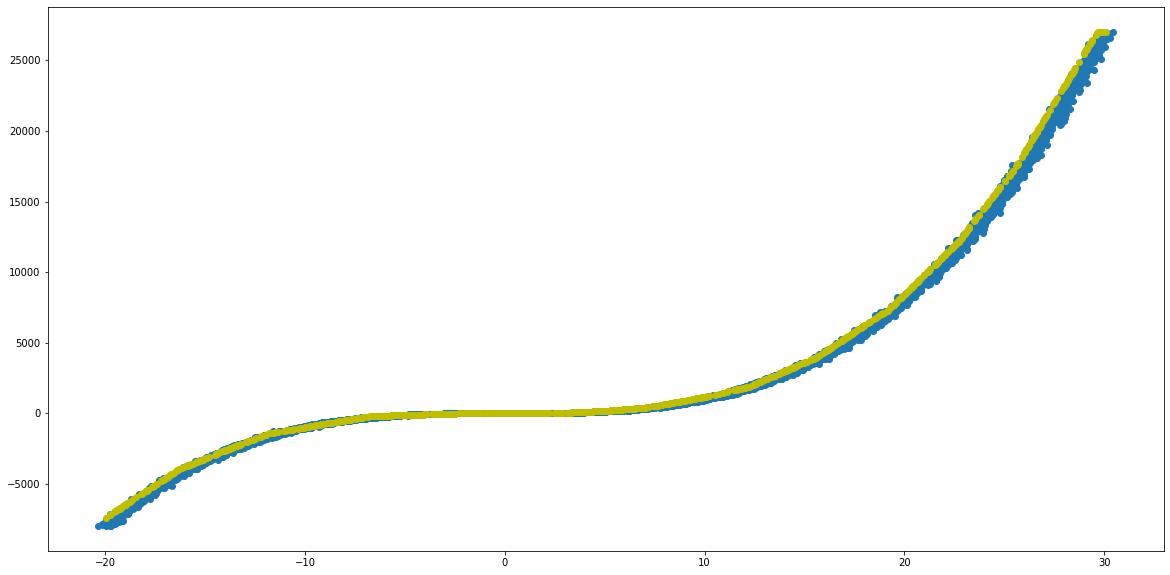

In [881]:
fitting(x3state_5_deep, 5)

In [882]:
net = NN_d(sz=5)
net.load_state_dict(x3state_5_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([5, 1])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([1, 5])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.6326)
tensor(1.9160)
tensor(2.0397)
tensor(1.5275)
tensor(1.6455)
tensor(1.6450)
tensor(2.0250)
tensor(1.2676)
tensor(1.4148)
tensor(1.2652)


### size 10

In [874]:
#x3state_10_deep = net.state_dict()

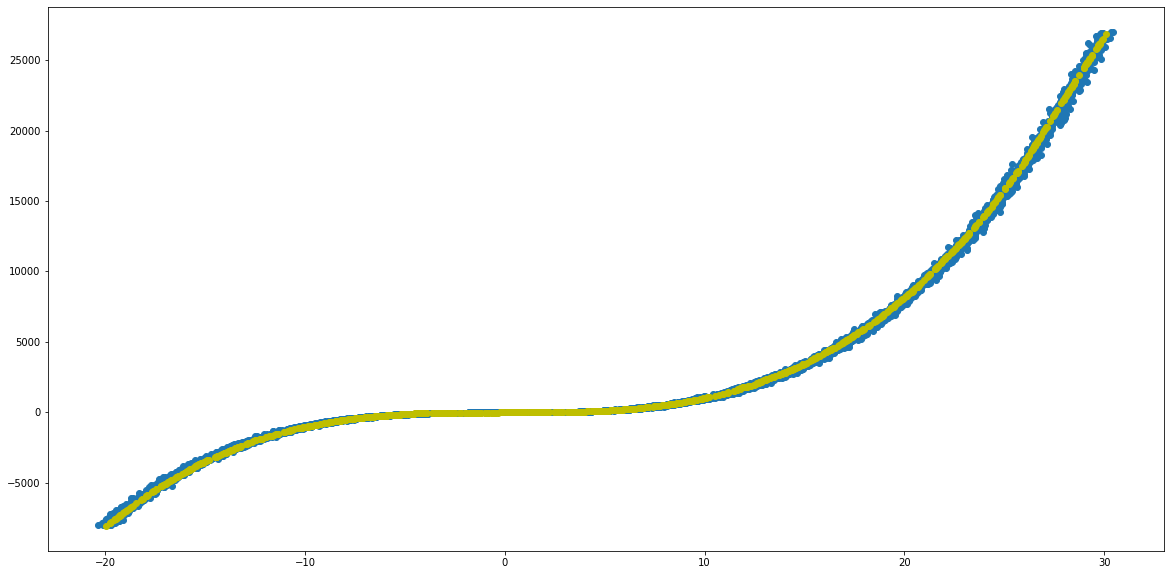

In [875]:
fitting(x3state_10_deep, 10)

In [876]:
net = NN(sz=10)
net.load_state_dict(x3state_10_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([10, 1])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([1, 10])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.9641)
tensor(2.1680)
tensor(2.1244)
tensor(2.5341)
tensor(2.7898)
tensor(2.6809)
tensor(2.9309)
tensor(2.5980)
tensor(1.8100)
tensor(1.5813)


### size 20

In [886]:
#x3state_20_deep = net.state_dict()

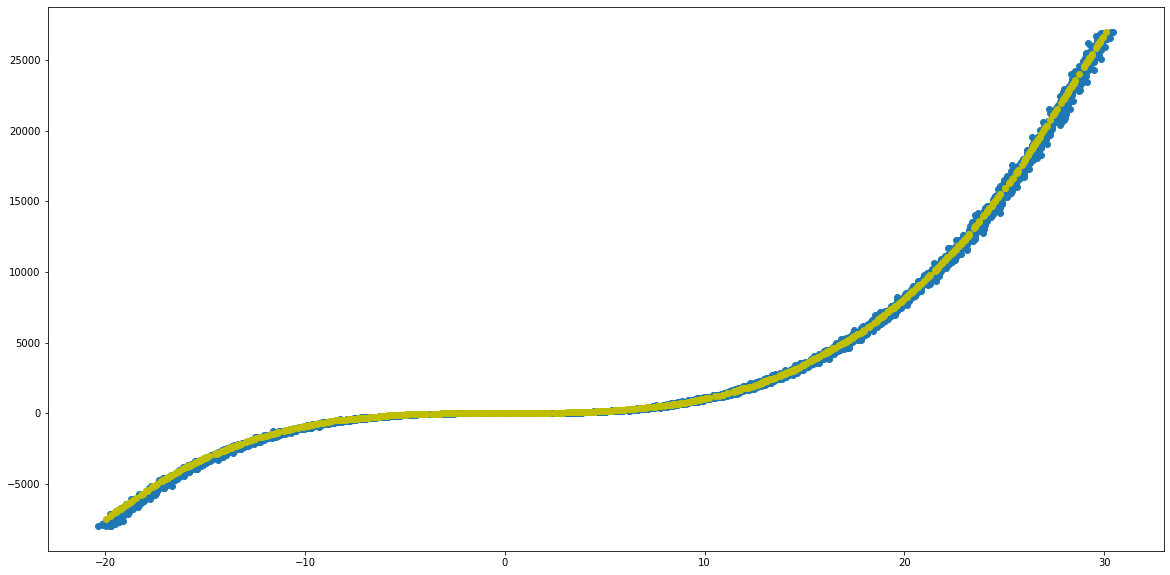

In [887]:
fitting(x3state_20_deep, 20)

In [888]:
net = NN(sz=20)
net.load_state_dict(x3state_20_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([20, 1])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([1, 20])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1.8979)
tensor(2.8424)
tensor(2.8629)
tensor(2.8309)
tensor(2.8067)
tensor(2.8062)
tensor(2.9198)
tensor(2.7858)
tensor(2.8167)
tensor(1.8306)


### size 160

In [892]:
#x3state_160_deep = net.state_dict()

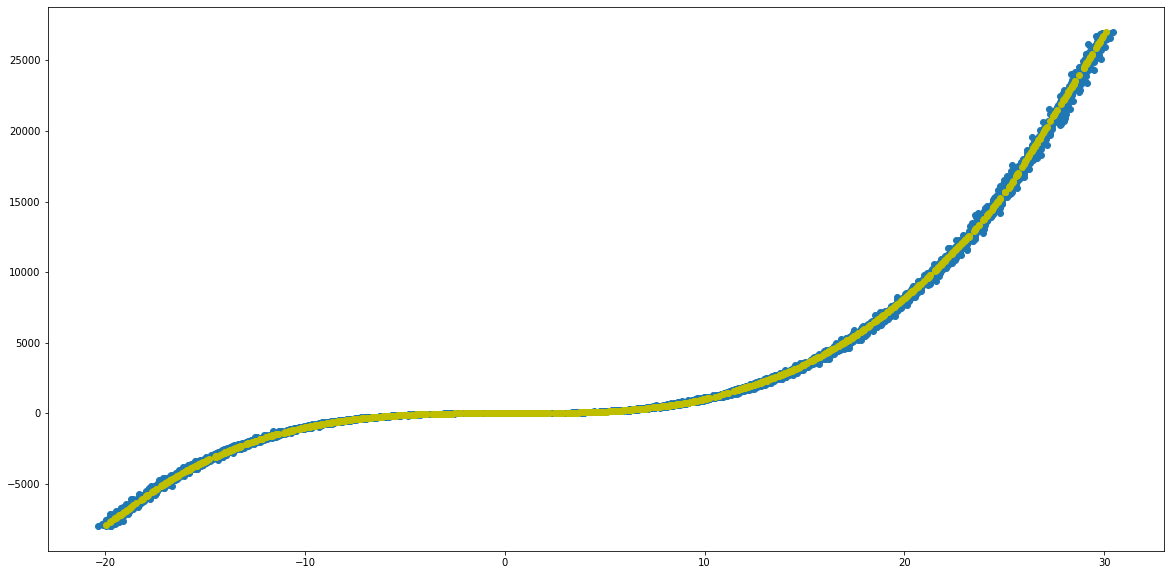

In [893]:
fitting(x3state_160_deep, 160)

In [894]:
net = NN(sz=160)
net.load_state_dict(x3state_160_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))

parameter size:  torch.Size([160, 1])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([1, 160])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(2.1778)
tensor(3.1487)
tensor(3.1598)
tensor(3.1477)
tensor(3.1563)
tensor(3.1539)
tensor(3.1548)
tensor(3.1569)
tensor(3.1497)
tensor(2.7665)


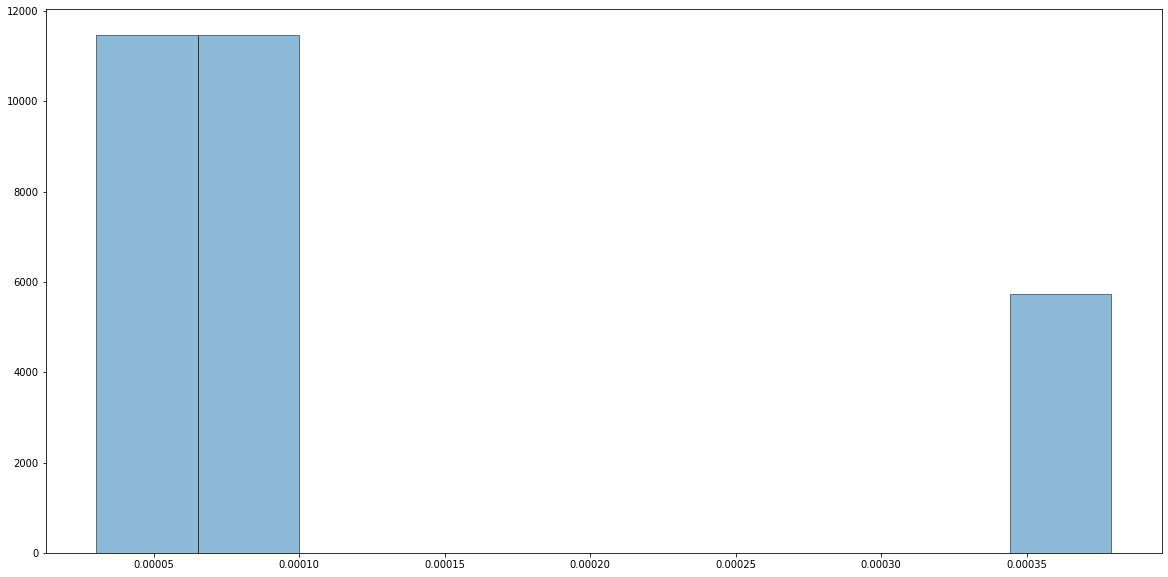

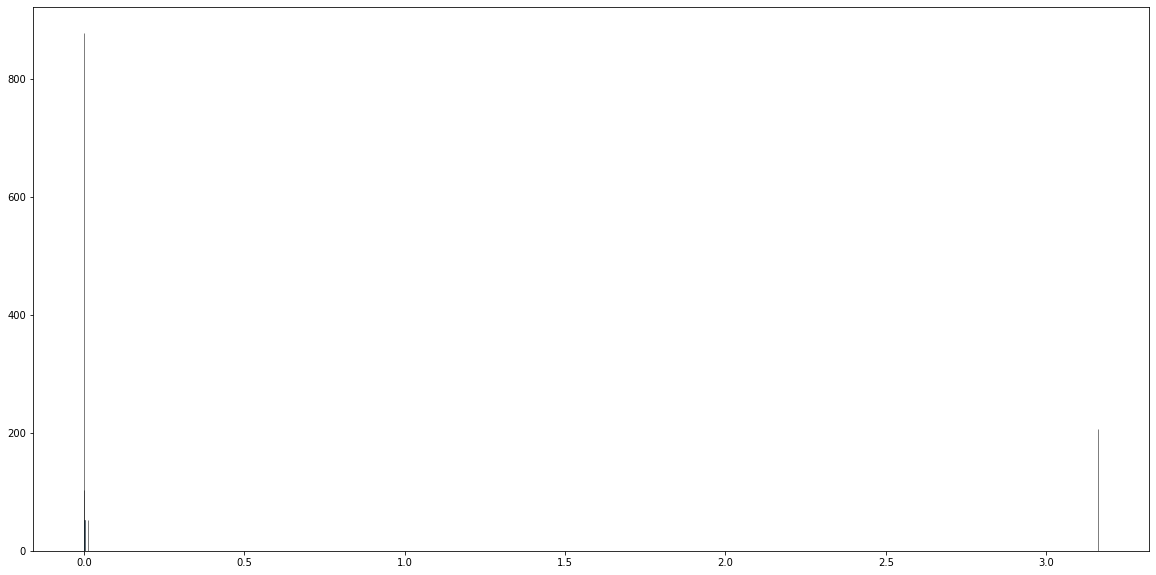

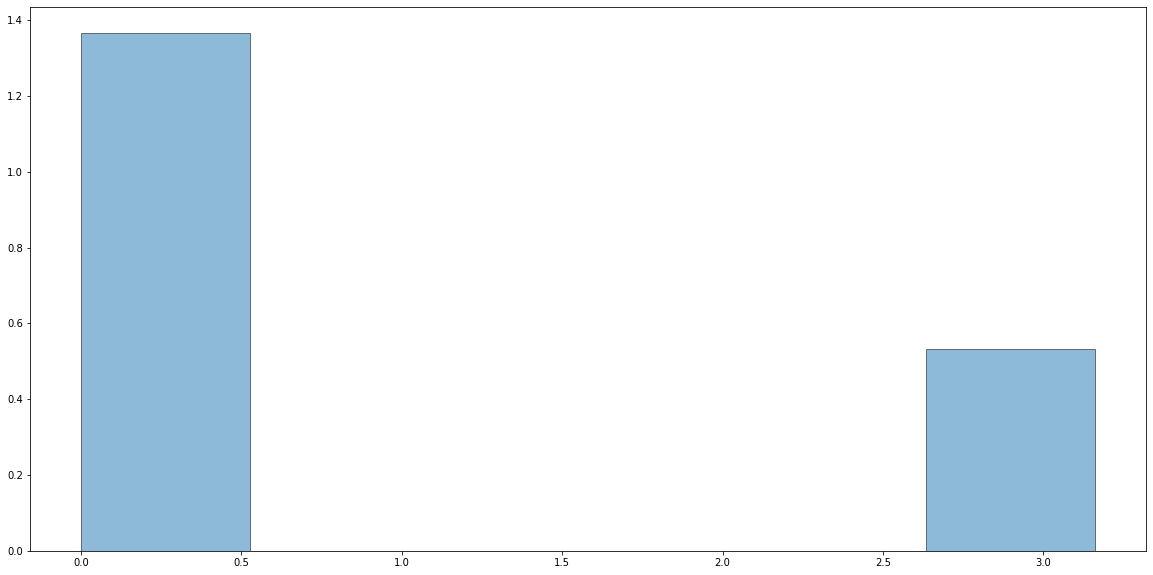

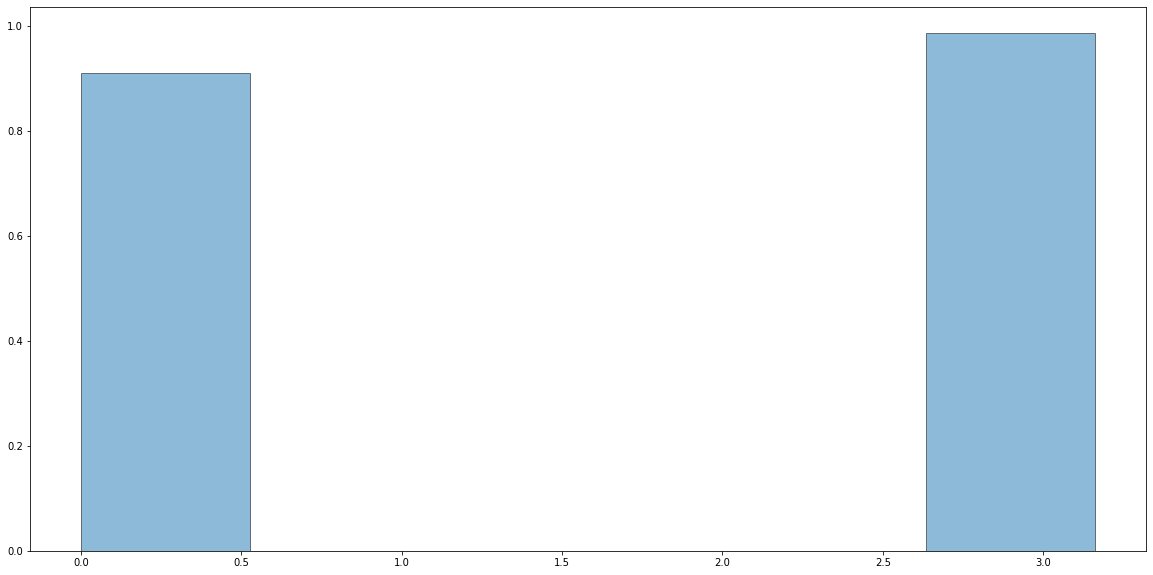

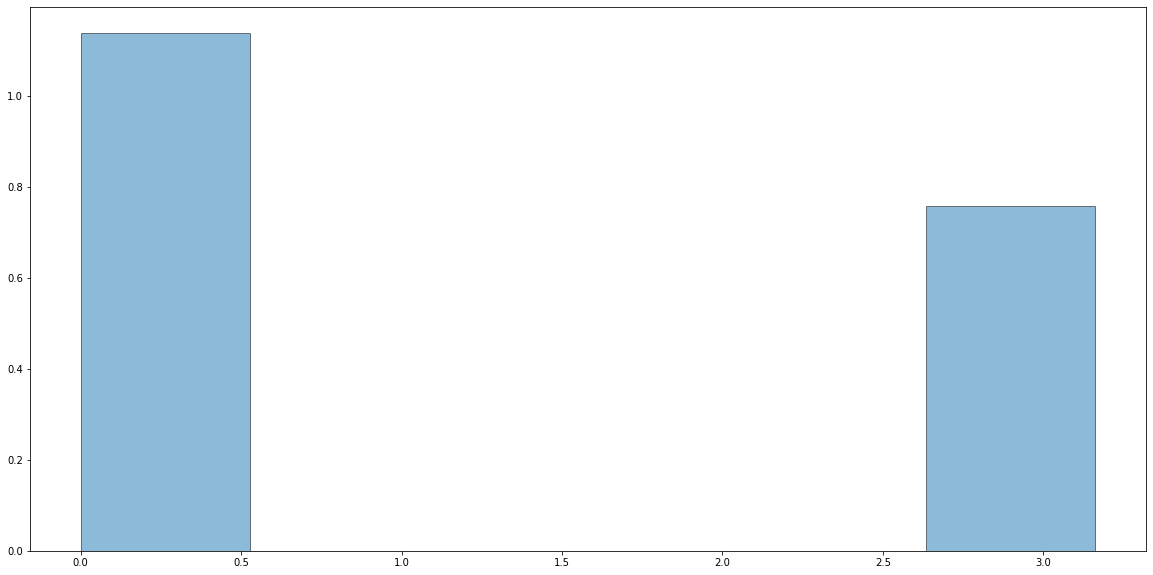

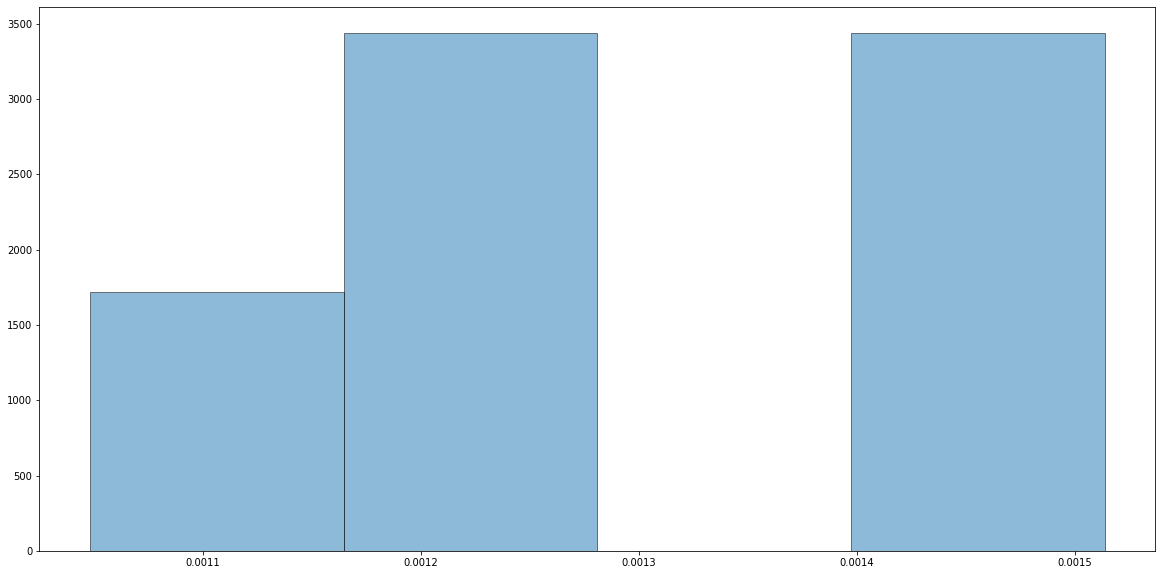

In [799]:
for i, tnsr in enumerate(perceptronDiagH):
    if i%2 == 0:
        plt.hist(torch.flatten(tnsr).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

0.weight


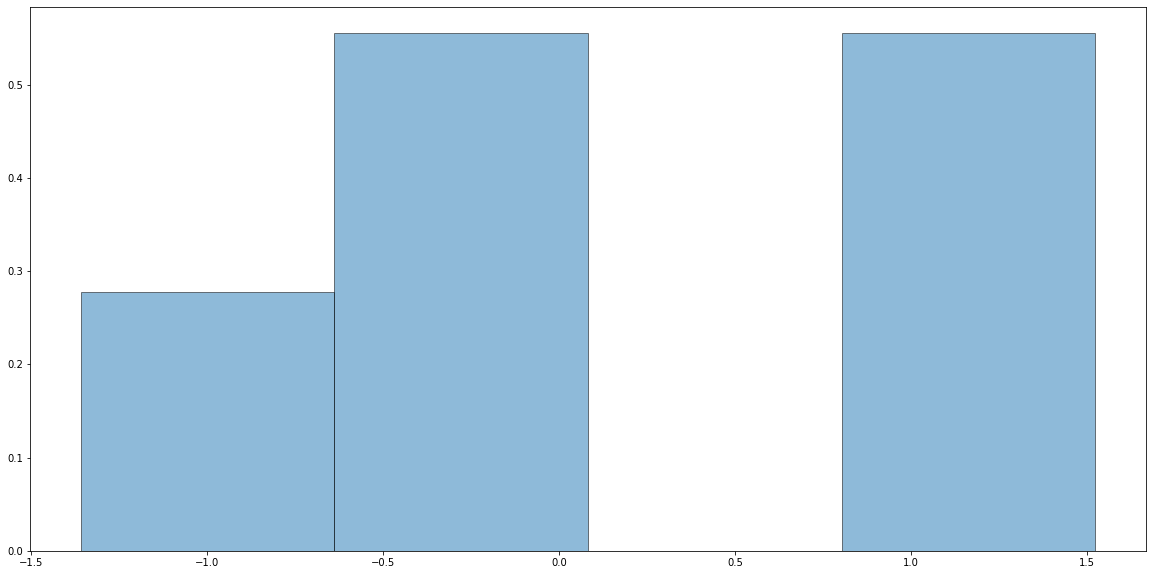

2.weight


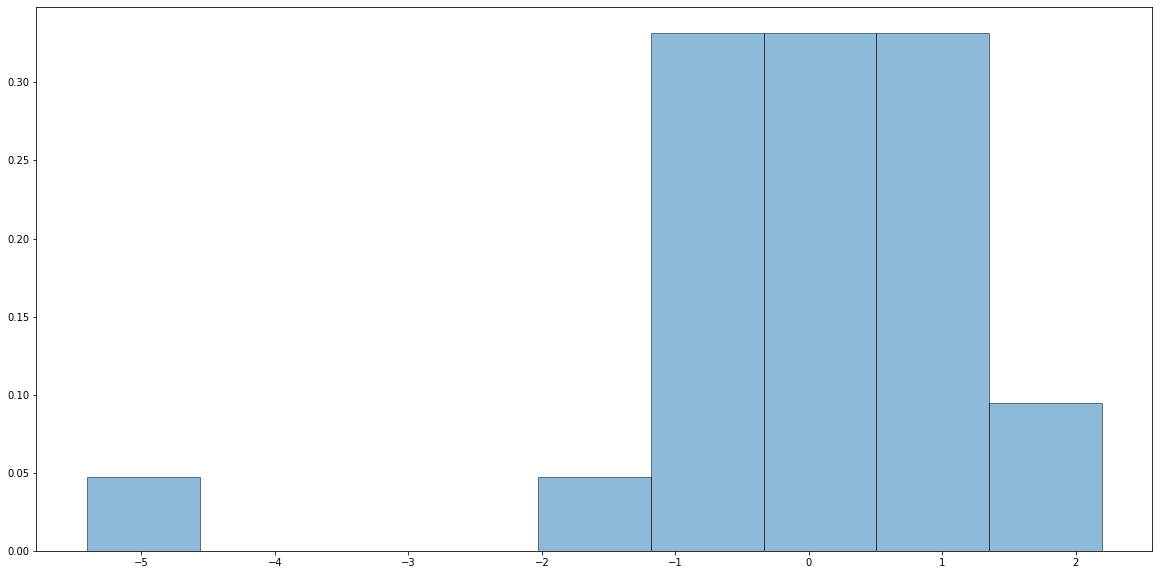

4.weight


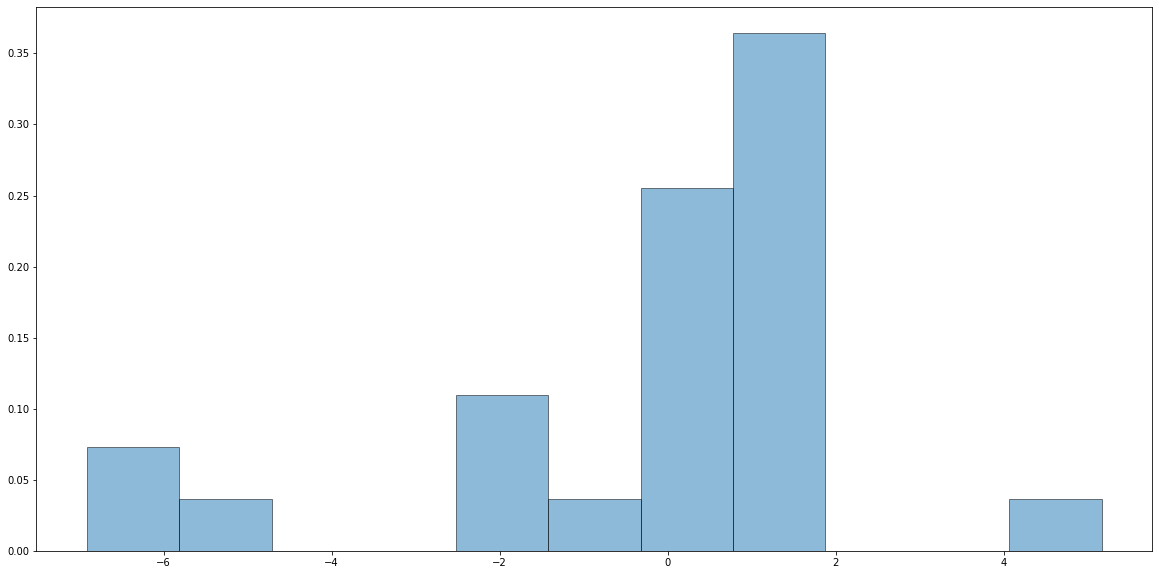

6.weight


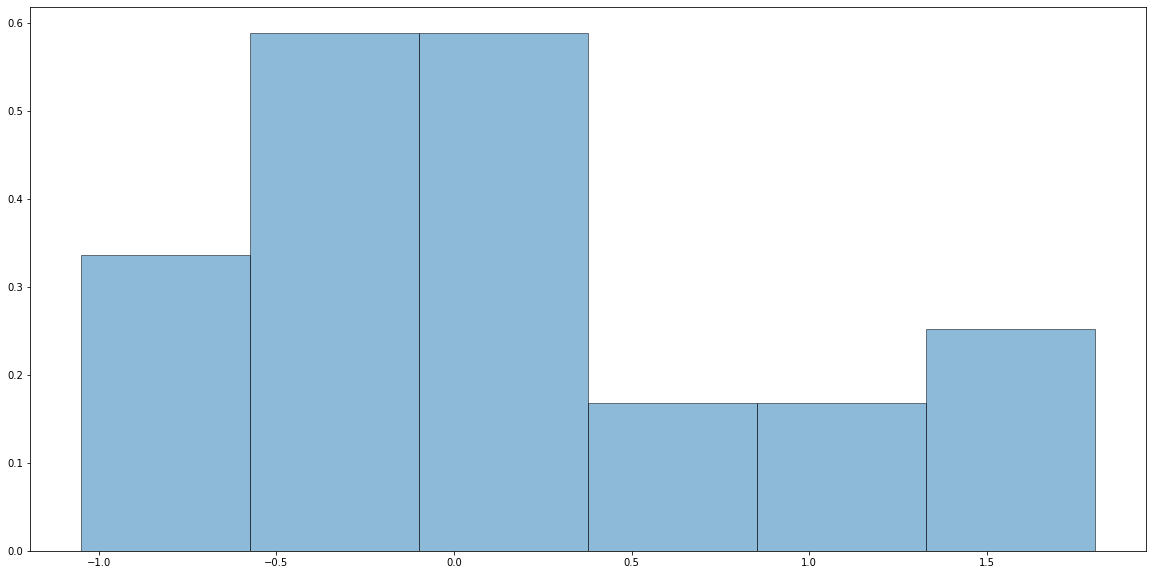

8.weight


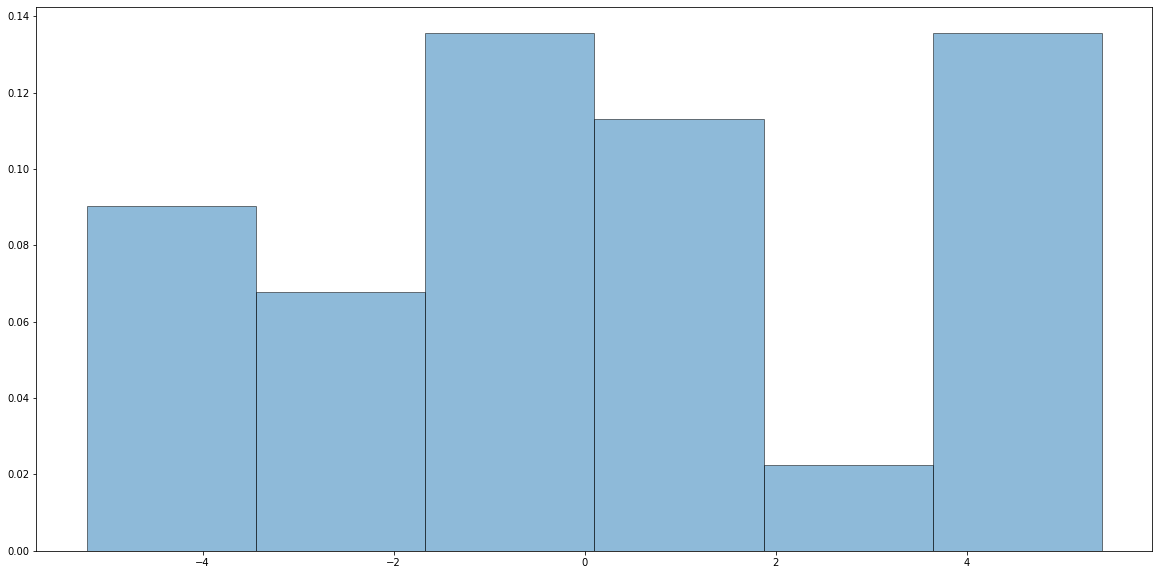

9.weight


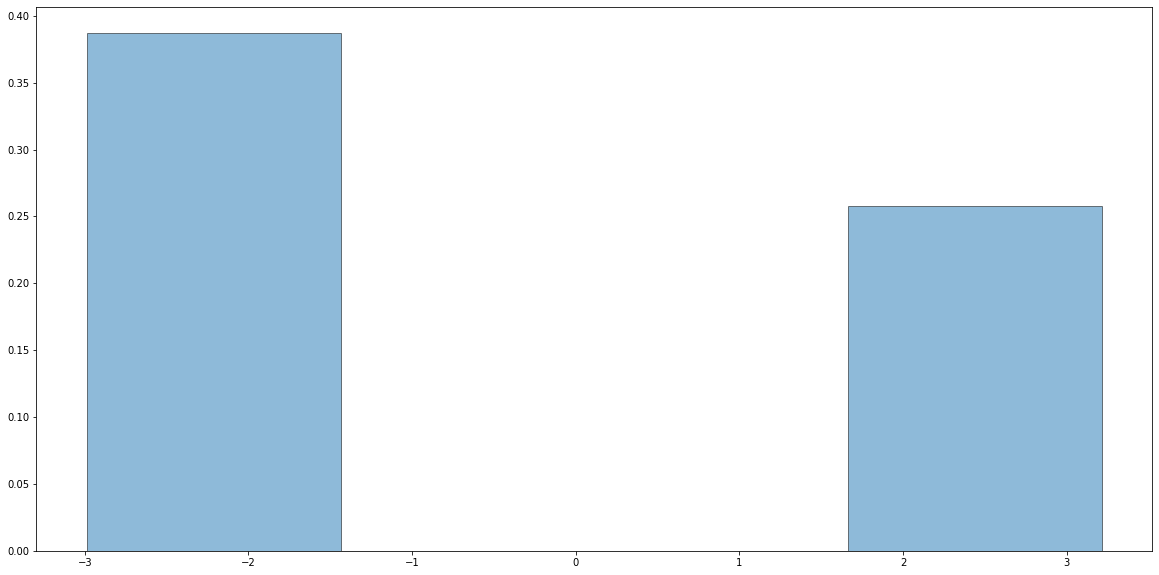

In [798]:
for i, (name, param) in enumerate(net.named_parameters()):
    if i%2 == 0:
        print(name)
        plt.hist(torch.flatten(param).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

layer index: 0
layer name: 0.weight
torch.Size([5, 1]) torch.Size([5, 1])

Pearsons correlation: -0.690


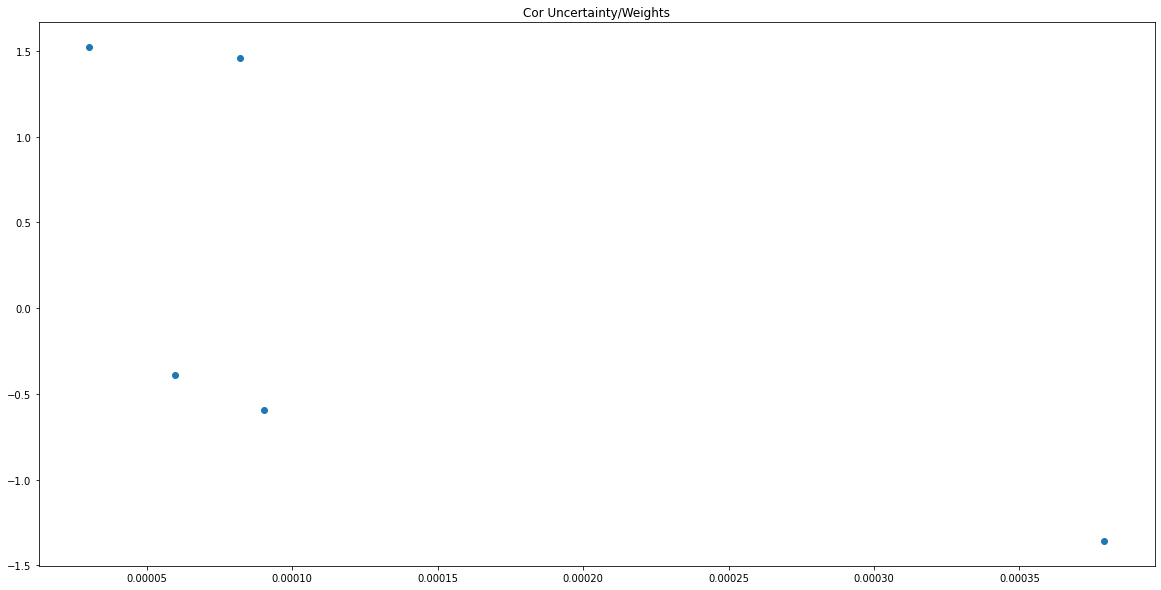

layer index: 2
layer name: 2.weight
torch.Size([5, 5]) torch.Size([5, 5])

Pearsons correlation: -0.152


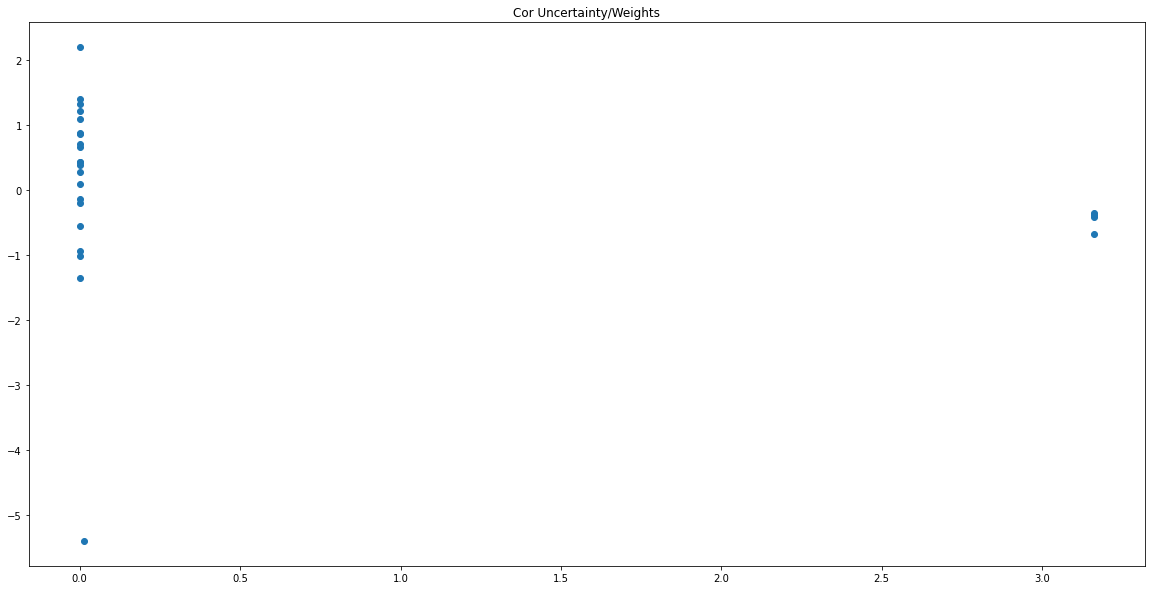

layer index: 4
layer name: 4.weight
torch.Size([5, 5]) torch.Size([5, 5])

Pearsons correlation: -0.032


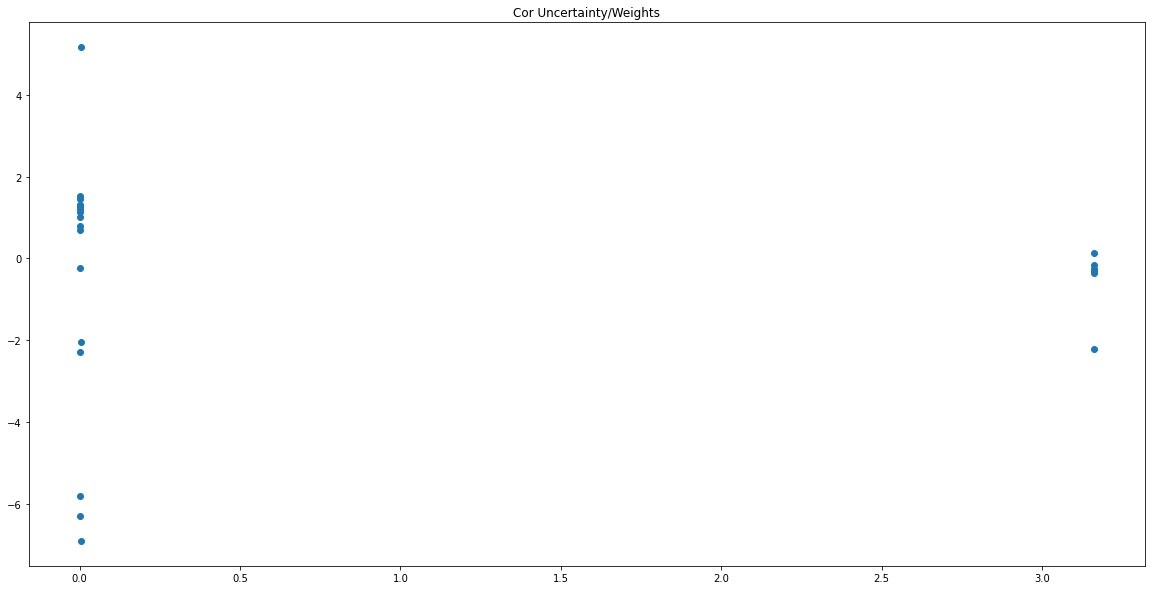

layer index: 6
layer name: 6.weight
torch.Size([5, 5]) torch.Size([5, 5])

Pearsons correlation: -0.311


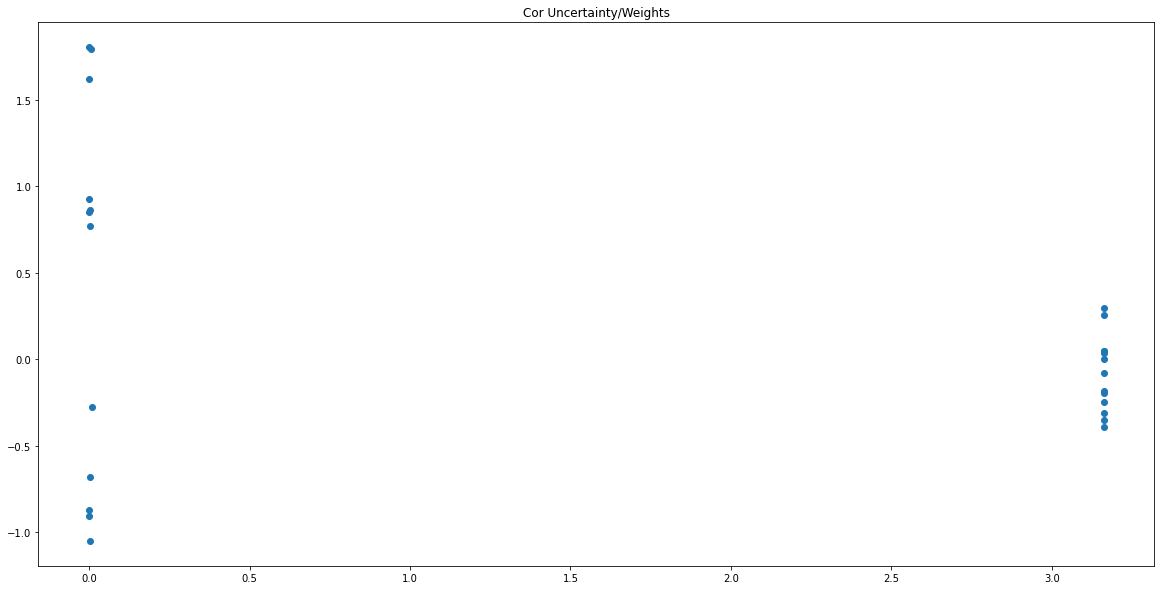

layer index: 8
layer name: 8.weight
torch.Size([5, 5]) torch.Size([5, 5])

Pearsons correlation: -0.074


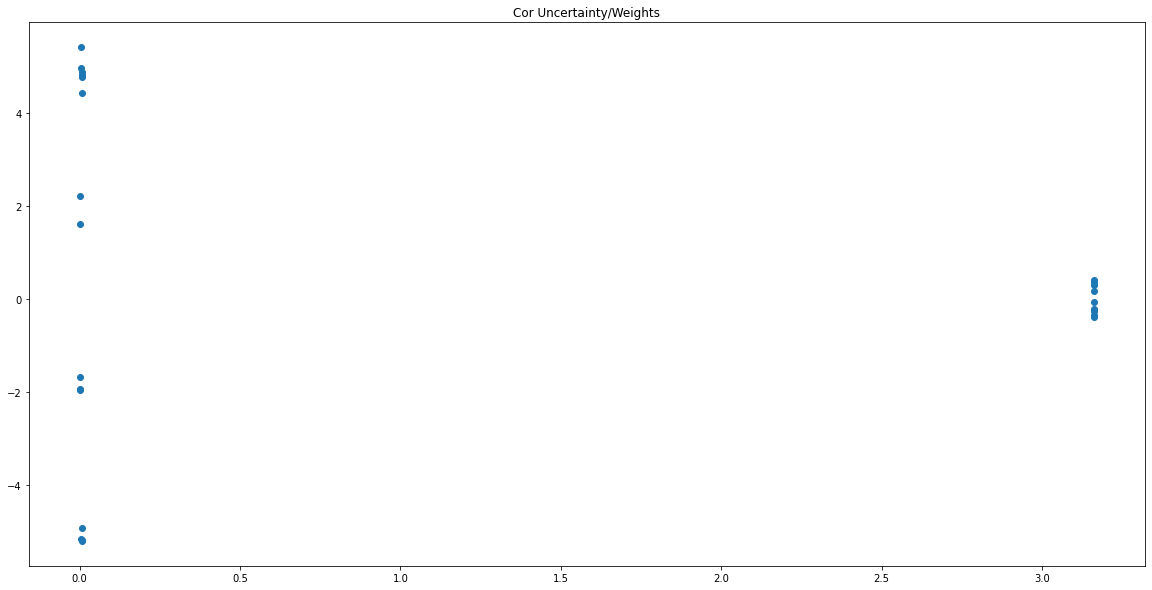

layer index: 10
layer name: 9.weight
torch.Size([1, 5]) torch.Size([1, 5])

Pearsons correlation: 0.072


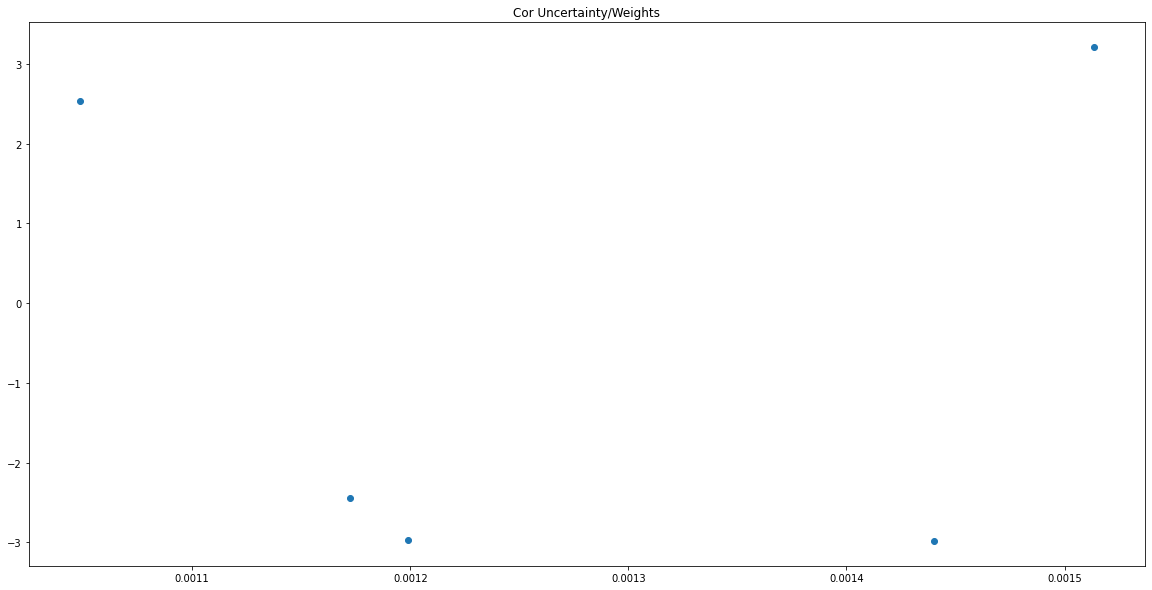

In [797]:
for i, tnsr in enumerate(perceptronDiagH):
    for j, (name, param) in enumerate(net.named_parameters()):
        if i == j and 'weight' in str(name):
            print('layer index: {}'.format(i))
            print('layer name: {}'.format(name))
            print(param.size(), tnsr.size())
            conv2_weights_flattened = torch.flatten(param)
            conv2_uncertainties_flattened = torch.flatten(tnsr)
            plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            plt.title('Cor Uncertainty/Weights')
            #print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
            corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            print()
            print('Pearsons correlation: %.3f' % corr)
            plt.show()

In [ ]:
for i, data4 in enumerate(data):
    X, y = iter(data4)
    if i > 1:
        break
print(X, y)
#X, y = load_mnist_data()
model = extend(net)
lossfunc = extend(torch.nn.MSELoss())
loss = lossfunc(model(torch.tensor([[X]]).float()), torch.tensor([[y]]).float())

#print(model(torch.tensor([[X]]).float()))
print(loss)

with backpack(DiagHessian()):
    loss.backward()

for name, param in model.named_parameters():
    #print(param.grad)
    print(name)
    #print(param.diag_h)